In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import tile_raster_images
import math
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

/Users/goran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/goran/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load mnist

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

## ZADATAK 1

In [4]:
def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def sample_prob(probs):
    """Uzorkovanje vektora x prema vektoru vjerojatnosti p(x=1) = probs"""
    return tf.to_float(tf.random_uniform(tf.shape(probs)) <= probs)

def draw_weights(W, shape, N, stat_shape=(20, 20), interpolation="bilinear"):
    """Vizualizacija težina
    W -- vektori težina
    shape -- tuple dimenzije za 2D prikaz težina - obično dimenzije ulazne slike, npr. (28,28)
    N -- broj vektora težina
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    image = (tile_raster_images(
        X=W.T,
        img_shape=shape,
        tile_shape=(int(math.ceil(N/stat_shape[0])), stat_shape[0]),
        tile_spacing=(1, 1)))
    plt.figure(figsize=(10, 14))
    plt.imshow(image, interpolation=interpolation)
    plt.axis('off')
    
def draw_reconstructions(ins, outs, states, shape_in, shape_state, N = 4):
    """Vizualizacija ulaza i pripadajućih rekonstrukcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    N -- broj uzoraka
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(N):
        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.axis('off')
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.axis('off')
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("States")
        plt.axis('off')
    plt.tight_layout()

def draw_generated(stin, stout, gen, shape_gen, shape_state, N):
    """Vizualizacija zadanih skrivenih stanja, konačnih skrivenih stanja i pripadajućih rekonstrukcija
    stin -- početni skriveni sloj 
    stout -- rekonstruirani vektori
    gen -- vektori stanja skrivenog sloja
    shape_gen -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    N -- broj uzoraka
    """
    plt.figure(figsize=(8, int(2 * N)))
    for i in range(N):

        plt.subplot(N, 4, 4*i + 1)
        plt.imshow(stin[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("set state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 2)
        plt.imshow(stout[i][0:784].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("final state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 3)
        plt.imshow(gen[i].reshape(shape_gen), vmin=0, vmax=1, interpolation="nearest")
        plt.title("generated visible")
        plt.axis('off')
    plt.tight_layout()

In [5]:
Nh = 100 # Broj elemenata prvog skrivenog sloja
h1_shape = (10,10)
Nv = 784 # Broj elemenata vidljivog sloja
v_shape = (28,28)
Nu = 5000 # Broj uzoraka za vizualizaciju rekonstrukcije

gibbs_sampling_steps = 1
alpha = 0.05

In [6]:
class RBM1: 
    def __init__(self, Nv, v_shape, Nh, h1_shape, gibbs_sampling_steps, alpha):
        self.g1 = tf.Graph()
        
        with self.g1.as_default():
            X1 = tf.placeholder("float", [None, 784])
            w1 = weights([Nv, Nh])
            vb1 = bias([Nv])
            hb1 = bias([Nh])

            v0 = X1
            h0_prob = tf.nn.sigmoid(tf.matmul(v0, w1) + tf.transpose(hb1))
            h0 = sample_prob(h0_prob)
            self.h0 = h0
            
            h1 = h0

            for step in range(gibbs_sampling_steps):
                v1_prob = tf.nn.sigmoid(tf.matmul(h1, tf.transpose(w1)) + tf.transpose(vb1))
                v1 = sample_prob(v1_prob)
                h1_prob = tf.nn.sigmoid(tf.matmul(v1, w1) + tf.transpose(hb1))
                h1 = sample_prob(h1_prob)
            
            # pozitivna faza
            w1_positive_grad = tf.matmul(tf.transpose(X1), h0_prob)

            # negativna faza
            w1_negative_grad = tf.matmul(tf.transpose(v1_prob), h1_prob)

            dw1 = (w1_positive_grad - w1_negative_grad) / tf.to_float(tf.shape(X1)[0])
            
            # osvjezavanje parametara RBMa
            update_w1 = tf.assign_add(w1, alpha * dw1)
            update_vb1 = tf.assign_add(vb1, alpha * tf.reduce_mean(X1 - v1_prob, 0))
            update_hb1 = tf.assign_add(hb1, alpha * tf.reduce_mean(h0 - h1, 0)) 

            self.out1 = (update_w1, update_vb1, update_hb1)
            
            # spremi podatke
            self.X1 = X1
            self.w1 = w1
            self.vb1 = vb1
            self.hb1 = hb1
            
            
            self.v1_prob = tf.nn.sigmoid(tf.matmul(h1, tf.transpose(w1)) + tf.transpose(vb1))
            self.v1 = sample_prob(self.v1_prob)
            self.h1_prob = h1_prob
            self.h1 = h1
            
            self.Nv = Nv
            self.Nh = Nh
            
            self.h1_shape = h1_shape
            self.v_shape = v_shape
            
            

            err1 = X1 - v1_prob
            self.err_sum1 = tf.reduce_mean(err1 * err1)

            self.initialize1 = tf.global_variables_initializer()
    
    def train(self, batch_size, epochs, mnist):
        n_samples = mnist.train.num_examples
        total_batch = int(n_samples / batch_size) * epochs
        
        self.sess = tf.Session(graph=self.g1)
        self.sess.run(self.initialize1)
        
        print("Total batches: ", total_batch)
        for i in range(total_batch):
            batch, label = mnist.train.next_batch(batch_size)
            err, _ = self.sess.run([self.err_sum1, self.out1], feed_dict={self.X1: batch})

            if i%(int(total_batch/10)) == 0:
                print("Batch count: ", i, "  Avg. reconstruction error: ", err)
    
    def get_params(self):
        w1s = self.sess.run(self.w1)
        vb1s = self.sess.run(self.vb1)
        hb1s = self.sess.run(self.hb1)
        return w1s, vb1s, hb1s
    
    def get_reconstruction_data(self):
        v1_probs, h1_probs, h1s = self.sess.run([self.v1_prob, self.h1_prob, self.h1], feed_dict={self.X1: teX[0:20,:]})
        return v1_probs, h1_probs, h1s

### RBM initialization

In [157]:
rbm = RBM1(Nv = 784, v_shape = (28, 28), Nh = 100, h1_shape = (10, 10), gibbs_sampling_steps = 1, alpha = 0.1)

In [158]:
rbm.train(batch_size = 100, epochs = 100, mnist = mnist)

Total batches:  55000
Batch count:  0   Avg. reconstruction error:  0.24794093
Batch count:  5500   Avg. reconstruction error:  0.01806269
Batch count:  11000   Avg. reconstruction error:  0.017083356
Batch count:  16500   Avg. reconstruction error:  0.015905945
Batch count:  22000   Avg. reconstruction error:  0.014595983
Batch count:  27500   Avg. reconstruction error:  0.01489799
Batch count:  33000   Avg. reconstruction error:  0.015852857
Batch count:  38500   Avg. reconstruction error:  0.01576008
Batch count:  44000   Avg. reconstruction error:  0.01519076
Batch count:  49500   Avg. reconstruction error:  0.0143774105


### Vizualizacija težina

In [159]:
w1s, vb1s, hb1s = rbm.get_params()

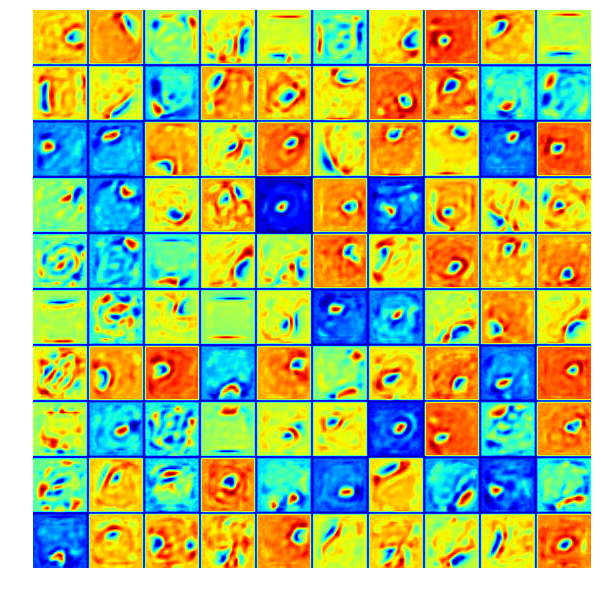

In [160]:
draw_weights(w1s, (28, 28), 100, (10, 10))

### Vizualizacije rekonstrukcije i stanja

In [161]:
v1_probs, h1_probs, h1s = rbm.get_reconstruction_data()

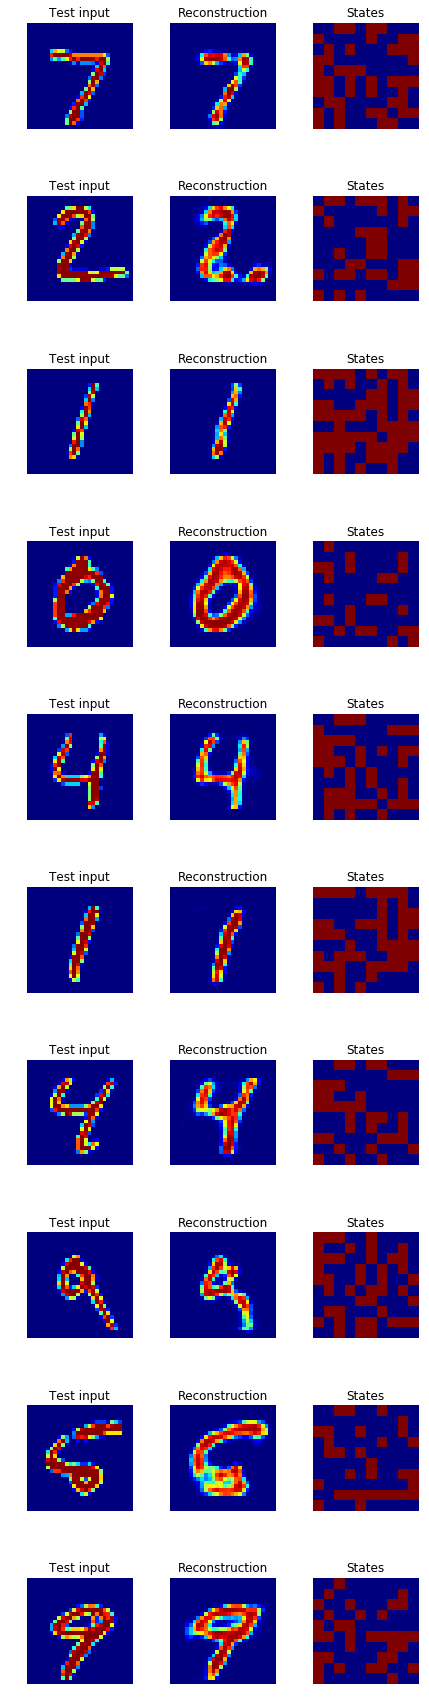

In [162]:
draw_reconstructions(teX, v1_probs, h1s, (28, 28), (10, 10), 10)

### Vizualizacija jedne rekonstrukcije s postepenim dodavanjem doprinosa aktivnih skrivenih elemenata

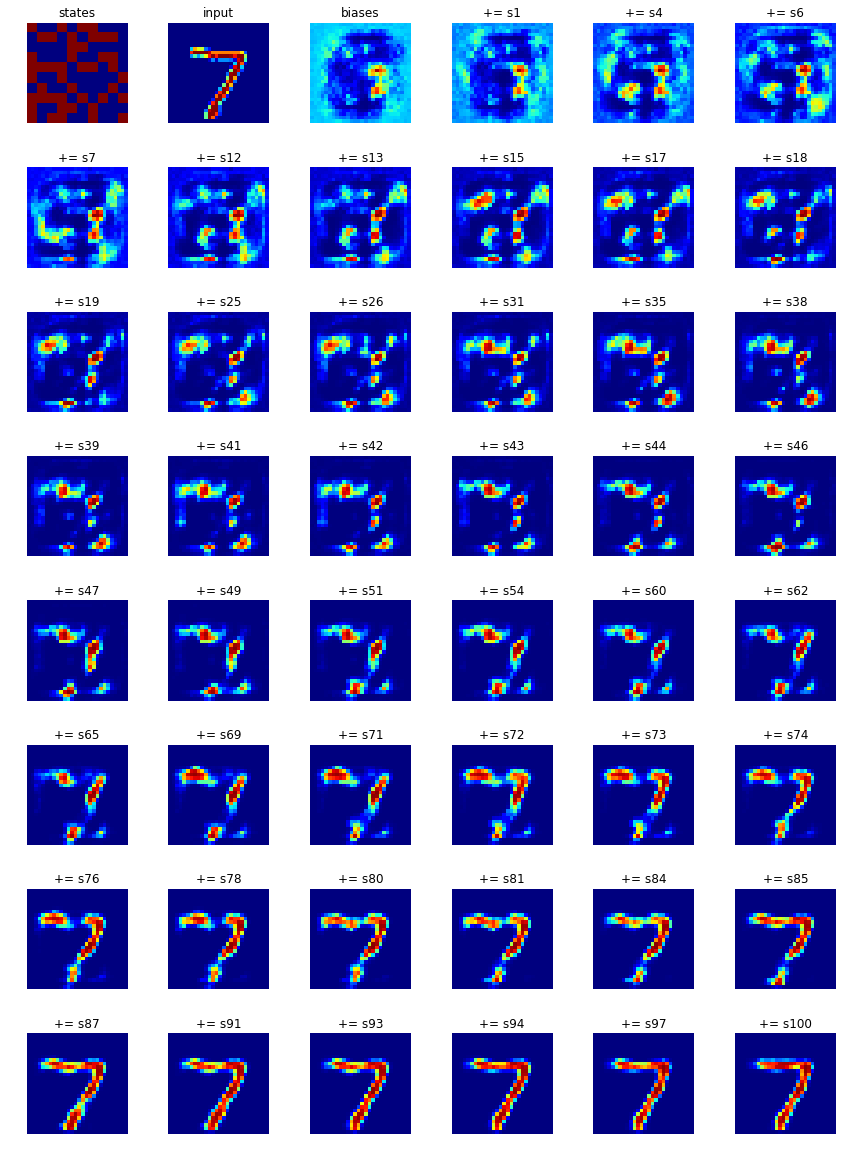

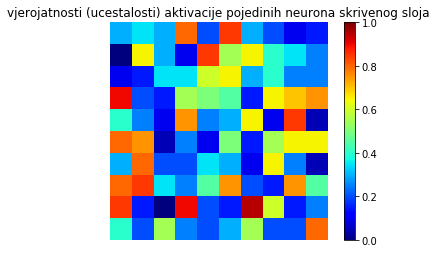

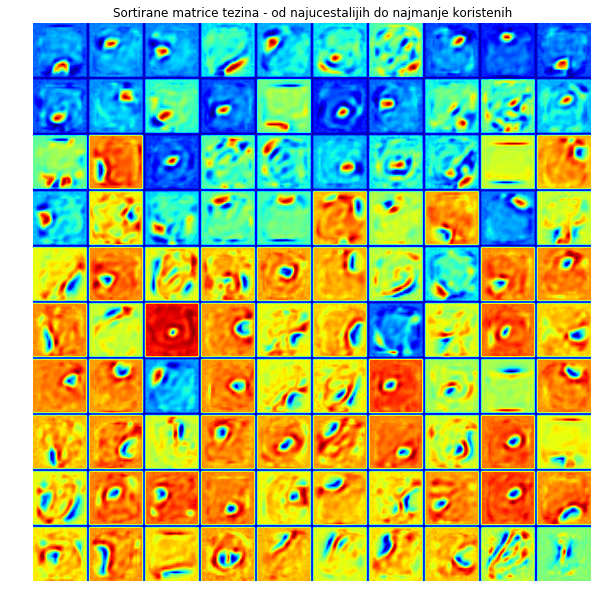

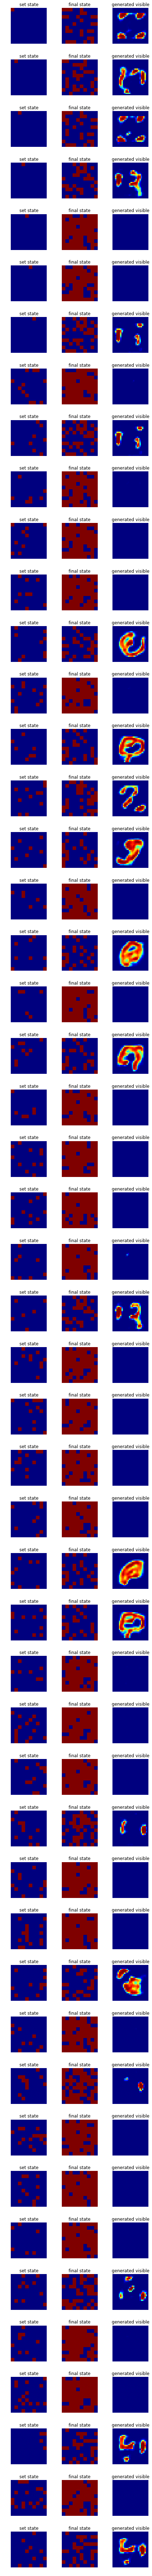

In [71]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def draw_rec(inp, title, size, Nrows, in_a_row, j):
    """ Iscrtavanje jedne iteracije u kreiranju vidljivog sloja
    inp - vidljivi sloj
    title - naslov sličice
    size - 2D dimenzije vidljiovg sloja
    Nrows - maks. broj redaka sličica
    in-a-row . broj sličica u jednom redu
    j - pozicija sličice u gridu
    """
    plt.subplot(Nrows, in_a_row, j)
    plt.imshow(inp.reshape(size), vmin=0, vmax=1, interpolation="nearest")
    plt.title(title)
    plt.axis('off')
    
    
def reconstruct(ind, states, orig, weights, biases):
    """ Slijedno iscrtavanje rekonstrukcije vidljivog sloja
    ind - indeks znamenke u orig (matrici sa znamenkama kao recima)
    states - vektori stanja ulaznih vektora
    orig - originalnalni ulazni vektori
    weights - matrica težina
    biases - vektori pomaka vidljivog sloja
    """
    j = 1
    in_a_row = 6
    Nimg = states.shape[1] + 3
    Nrows = int(np.ceil(float(Nimg+2)/in_a_row))
    
    plt.figure(figsize=(12, 2*Nrows))
       
    draw_rec(states[ind], 'states', h1_shape, Nrows, in_a_row, j)
    j += 1
    draw_rec(orig[ind], 'input', v_shape, Nrows, in_a_row, j)
    
    reconstr = biases.copy()
    j += 1
    draw_rec(sigmoid(reconstr), 'biases', v_shape, Nrows, in_a_row, j)
    
    for i in range(Nh):
        if states[ind,i] > 0:
            j += 1
            reconstr = reconstr + weights[:,i]
            titl = '+= s' + str(i+1)
            draw_rec(sigmoid(reconstr), titl, v_shape, Nrows, in_a_row, j)
    plt.tight_layout()
    
reconstruct(0, h1s, teX, w1s, vb1s) # prvi argument je indeks znamenke u matrici znamenki

# Vjerojatnost da je skriveno stanje uključeno kroz Nu ulaznih uzoraka
plt.figure()
tmp = (h1s.sum(0)/h1s.shape[0]).reshape(h1_shape)
plt.imshow(tmp, vmin=0, vmax=1, interpolation="nearest")
plt.axis('off')
plt.colorbar()
plt.title('vjerojatnosti (ucestalosti) aktivacije pojedinih neurona skrivenog sloja')

# Vizualizacija težina sortitranih prema učestalosti
tmp_ind = (-tmp).argsort(None)
draw_weights(w1s[:, tmp_ind], v_shape, Nh, h1_shape)
plt.title('Sortirane matrice tezina - od najucestalijih do najmanje koristenih')

# Generiranje uzoraka iz slučajnih vektora
r_input = np.random.rand(100, Nh)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

out_1 = rbm.sess.run((rbm.v1), feed_dict={rbm.h0: r_input})

# Emulacija dodatnih Gibbsovih uzorkovanja pomoću feed_dict
for i in range(1000):
    out_1_prob, out_1, hout1 = rbm.sess.run((rbm.v1_prob, rbm.v1, rbm.h1), feed_dict={rbm.X1: out_1})

draw_generated(r_input, hout1, out_1_prob, (28, 28), (10, 10), 50)

### ZADATAK 2

In [94]:
class RBM2:
    
    def __init__(self, Nv, v_shape, Nh, h1_shape, Nh2, h2, gibbs_sampling_steps, alpha, w1s):

        self.g2 = tf.Graph()
        with self.g2.as_default():
            X2 = tf.placeholder("float", [None, Nv])
            w1 = tf.Variable(w1s)
            vb1 = tf.Variable(vb1s)
            hb1 = tf.Variable(hb1s)

            w2 = weights([Nh, Nh2])
            vb2 = bias([Nh])
            hb2 = bias([Nh2])

            # vidljivi sloj drugog RBM-a
            v2_prob  = tf.nn.sigmoid(tf.matmul(X2, w1) + tf.transpose(hb1))
            v2 = sample_prob(v2_prob)

            # skriveni sloj drugog RBM-a
            h2_prob = tf.nn.sigmoid(tf.matmul(v2, w2) + tf.transpose(hb2)) 
            h2 = sample_prob(h2_prob)

            h3 = h2

            for step in range(gibbs_sampling_steps):
                v3_prob = tf.nn.sigmoid(tf.matmul(h3, tf.transpose(w2)) + tf.transpose(vb2)) 
                v3 = sample_prob(v3_prob)

                h3_prob = tf.nn.sigmoid(tf.matmul(v3, w2) + tf.transpose(hb2)) 
                h3 = sample_prob(h3_prob)

            w2_positive_grad = tf.matmul(tf.transpose(v2_prob), h2_prob)
            w2_negative_grad = tf.matmul(tf.transpose(v3_prob), h3_prob)

            dw2 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(v2)[0])

            update_w2 = tf.assign_add(w2, alpha * dw2)
            update_vb2 = tf.assign_add(vb2, alpha * tf.reduce_mean(v2 - v3, 0))
            update_hb2 = tf.assign_add(hb2, alpha * tf.reduce_mean(h2 - h3, 0))

            self.out2 = (update_w2, update_vb2, update_hb2)

            # rekonsturkcija ulaza na temelju krovnog skrivenog stanja h3
            v4_prob = tf.nn.sigmoid(tf.matmul(h3, tf.transpose(w2)) + tf.transpose(vb2)) 
            v4 = sample_prob(v4_prob)
            
            v5_prob = tf.nn.sigmoid(tf.matmul(v4, tf.transpose(w1a)) + tf.transpose(vb1a)) 
            
            err2 = X2 - v5_prob
            self.err_sum2 = tf.reduce_mean(err2 * err2)

            self.initialize2 = tf.global_variables_initializer()
            
            self.X2 = X2
            self.w2 = w2
            self.vb2 = vb2
            self.hb2 = hb2
            self.v5_prob = v5_prob
            self.h3_prob = h3_prob
            self.h3 = h3
            
            self.Nv = Nv
            self.Nh = Nh
            self.v_shape = v_shape
            self.h1_shape = h1_shape
            
            
            self.h1_shape = h1_shape
            self.Nh2 = Nh2
            self.v_shape = v_shape
            self.h2_shape = h2_shape
            
    def train(self, batch_size, epochs, mnist):
        n_samples = mnist.train.num_examples

        total_batch = int(n_samples / batch_size) * epochs
        self.sess = tf.Session(graph=self.g2)
        self.sess.run(self.initialize2)

        for i in range(total_batch):
            self.batch, label = mnist.train.next_batch(batch_size)
            err, _ = self.sess.run([self.err_sum2, self.out2], feed_dict={self.X2: self.batch})

            if i%(int(total_batch/10)) == 0:
                print("Batch count: ", i, "  Avg. reconstruction error: ", err)
        
    def plot_all(self):
        w2s, vb2s, hb2s = self.sess.run([self.w2, self.vb2, self.hb2], feed_dict={self.X2: self.batch})
        vr2, h3_probs, h3s = self.sess.run([self.v5_prob, self.h3_prob, self.h3], feed_dict={self.X2: teX[0:50,:]})

        # vizualizacija težina
        draw_weights(w2s, self.h1_shape, self.Nh2, interpolation="nearest")

        # vizualizacija rekonstrukcije i stanja
        draw_reconstructions(teX, vr2, h3s, self.v_shape, self.h2_shape)
        
        
    def get_params(self):
        w2s = self.sess.run(self.w2)
        v2bs = self.sess.run(self.vb2)
        hb2s = self.sess.run(self.hb2)
        return w2s, v2bs, hb2s
    
    def get_vr(self):
        vr = self.sess.run(self.v5_prob, feed_dict={self.X2: teX[0:50,:]})
        return vr

In [95]:
Nv = 784
v_shape = (28,28)
Nh = 100
h1_shape = (10,10)

Nh2 = 100
h2_shape = (10,10) 

gibbs_sampling_steps = 2
alpha = 0.1
w1s, vb1s, hb1s = rbm.get_params()

batch_size = 100
epochs = 100

In [96]:
rbm2 = RBM2(Nv, v_shape, Nh, h1_shape, Nh2, h2_shape, gibbs_sampling_steps, alpha, w1s)
rbm2.train(batch_size, epochs, mnist)

Batch count:  0   Avg. reconstruction error:  0.105895385
Batch count:  5500   Avg. reconstruction error:  0.037825312
Batch count:  11000   Avg. reconstruction error:  0.036931332
Batch count:  16500   Avg. reconstruction error:  0.03820394
Batch count:  22000   Avg. reconstruction error:  0.035057362
Batch count:  27500   Avg. reconstruction error:  0.035750233
Batch count:  33000   Avg. reconstruction error:  0.037161518
Batch count:  38500   Avg. reconstruction error:  0.034982935
Batch count:  44000   Avg. reconstruction error:  0.034253214
Batch count:  49500   Avg. reconstruction error:  0.033588495


### Vizualizacija težina

In [98]:
w2s, _, _ = rbm2.get_params()

### W1

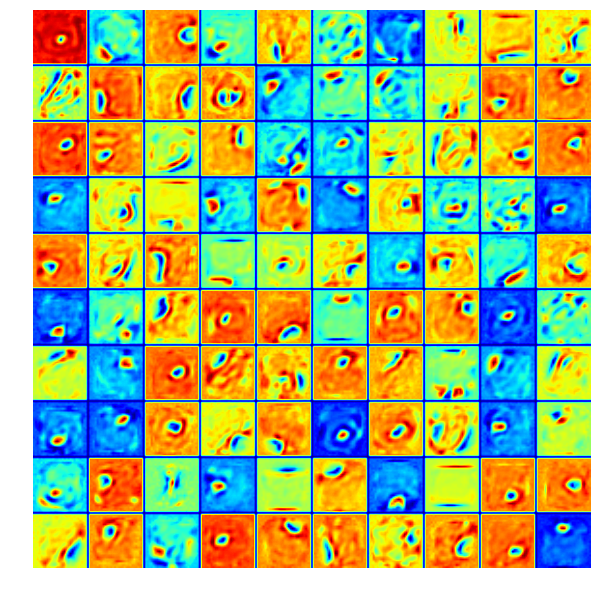

In [110]:
draw_weights(w1s, (28, 28), 100, (10, 10))

### W2

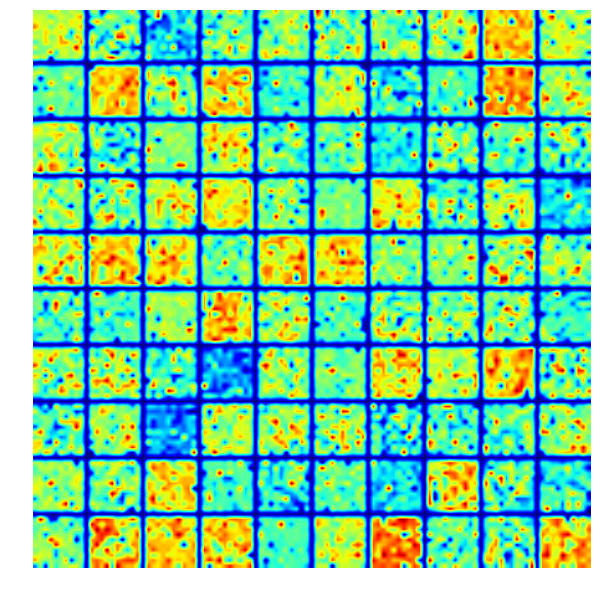

In [101]:
draw_weights(w2s, (10, 10), 100, (10, 10))

### Vizualizacije rekonstrukcije i stanja

In [111]:
vr2, h3_probs, h3s = rbm2.sess.run([rbm2.v5_prob, rbm2.h3_prob, rbm2.h3], feed_dict={rbm2.X2: teX[0:50,:]})

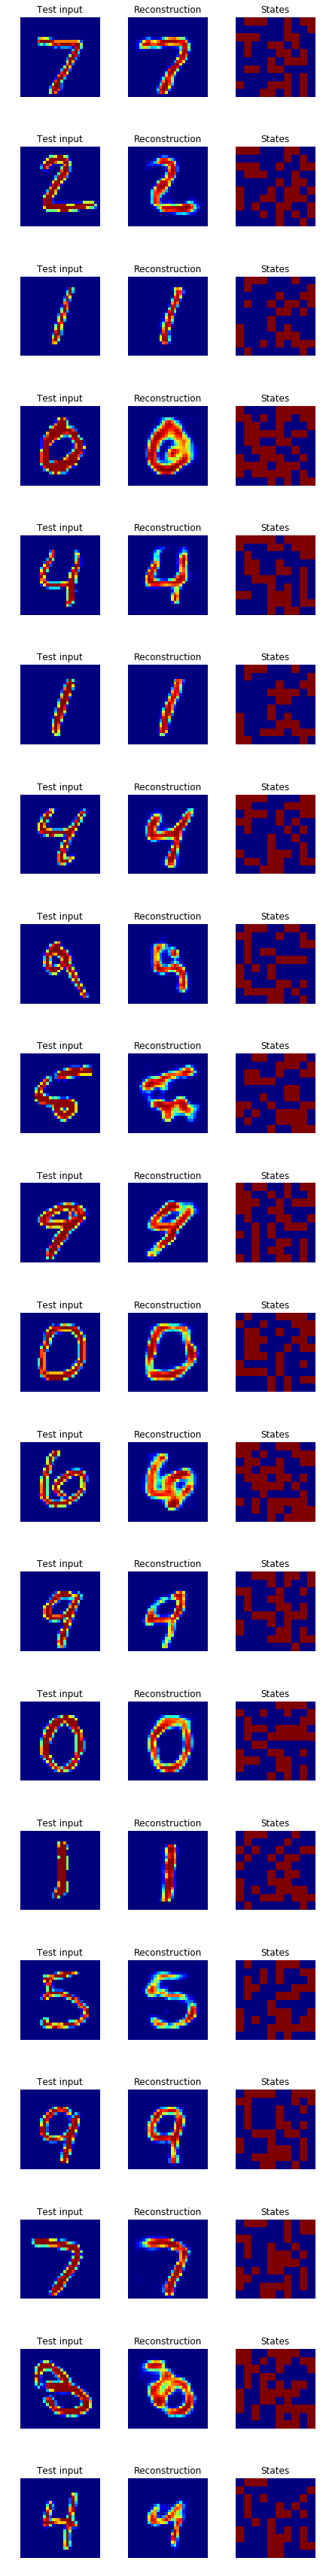

In [112]:
draw_reconstructions(teX, vr2, h3s, rbm2.v_shape, rbm2.h2_shape, 20)

## ZADATAK 2 + 3

In [124]:
class RBM3:
    def __init__(self, Nv, v_shape, Nh, h1_shape, Nh2, h2, beta, w1s, w2s):

        beta = 0.01

        self.g3 = tf.Graph()
        with self.g3.as_default():   
            X3 = tf.placeholder("float", [None, Nv])


            w1_up = tf.Variable(w1s)
            w1_down = tf.Variable(tf.transpose(w1s))
            w2a = tf.Variable(w2s)

            hb1_up = tf.Variable(hb1s)
            hb1_down = tf.Variable(vb2s)

            vb1_down = tf.Variable(vb1s)
            hb2a = tf.Variable(hb2s)

            v1= X3
            
            # wake pass
            h1_up_prob = tf.nn.sigmoid(tf.matmul(v1, w1_up) + tf.transpose(hb1_up)) 
            h1_up = sample_prob(h1_up_prob) # s^{(n)} u pripremi

            v1_up_down_prob = tf.nn.sigmoid(tf.matmul(h1_up, w1_down) + tf.transpose(vb1_down)) 
            v1_up_down = sample_prob(v1_up_down_prob) # s^{(n-1)\mathit{novo}} u pripremi


            # top RBM Gibs passes
            h2_up_prob = tf.nn.sigmoid(tf.matmul(h1_up, w2a) + tf.transpose(hb2a)) 
            h2_up = sample_prob(h2_up_prob)
            h4 = h2_up

            for step in range(gibbs_sampling_steps):
                h1_down_prob = tf.nn.sigmoid(tf.matmul(h4, tf.transpose(w2a)) + tf.transpose(hb1_down)) 
                h1_down = sample_prob(h1_down_prob)

                h4_prob = tf.nn.sigmoid(tf.matmul(h1_down, w2a) + tf.transpose(hb2a)) 
                h4 = sample_prob(h4_prob)

            # sleep pass
            v1_down_prob = tf.nn.sigmoid(tf.matmul(h1_down, w1_down) + tf.transpose(vb1_down)) 
            v1_down = sample_prob(v1_down_prob) # s^{(n-1)} u pripremi

            h1_down_up_prob = tf.nn.sigmoid(tf.matmul(v1_down, w1_up) + tf.transpose(hb1_up)) 
            h1_down_up = sample_prob(h1_down_prob) # s^{(n)\mathit{novo}} u pripremi


            # generative weights update during wake pass
            update_w1_down = tf.assign_add(w1_down, beta * tf.matmul(tf.transpose(h1_up), X3 - v1_up_down_prob) / tf.to_float(tf.shape(X3)[0]))
            update_vb1_down = tf.assign_add(vb1_down, beta * tf.reduce_mean(X3 - v1_up_down_prob, 0))

            # top RBM update
            w2_positive_grad = self.get_w_grad(h1_up_prob, h2_up_prob)
            w2_negative_grad = self.get_w_grad(h1_down_prob, h4_prob)
            
            dw3 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(h1_up)[0]) 


            update_w2 = tf.assign_add(w2a, beta * dw3)
            update_hb1_down = tf.assign_add(hb1_down, beta * tf.reduce_mean(h1_up - h1_down, 0))
            update_hb2 = tf.assign_add(hb2a, beta * tf.reduce_mean(h2_up - h4, 0))

            # recognition weights update during sleep pass
            update_w1_up = tf.assign_add(w1_up, beta * tf.matmul(tf.transpose(v1_down_prob), h1_down - h1_down_up) / tf.to_float(tf.shape(X3)[0]))
            update_hb1_up = tf.assign_add(hb1_up, beta * tf.reduce_mean(h1_down - h1_down_up, 0))###########^ #####

            self.out3 = (update_w1_down, update_vb1_down, update_w2, update_hb1_down, update_hb2, update_w1_up, update_hb1_up)

            err3 = X3 - v1_down_prob
            self.err_sum3 = tf.reduce_mean(err3 * err3)

            self.initialize3 = tf.initialize_all_variables()
            
            
            self.X3 = X3
            self.w2a, self.w1_up, self.w1_down, self.hb2a = w2a, w1_up, w1_down, hb2a
            self.hb1_up, self.hb1_down, self.vb1_down =  hb1_up, hb1_down, vb1_down
            self.v1_down_prob, self.h4, self.h4_prob = v1_down_prob, h4, h4_prob
            
            self.h2_up = h2_up
            
            self.Nv = Nv
            self.Nh = Nh
            self.v_shape = v_shape
            self.h1_shape = h1_shape
            
            
            self.h1_shape = h1_shape
            self.Nh2 = Nh2
            self.v_shape = v_shape
            self.h2_shape = h2_shape
            
    def get_w_grad(self, v, h):
        return tf.matmul(tf.transpose(v), h)
            
    def train(self, batch_size, epochs, mnist):
        n_samples = mnist.train.num_examples
        total_batch = int(n_samples / batch_size) * epochs
        self.sess = tf.Session(graph=self.g3)
        self.sess.run(self.initialize3)

        for i in range(total_batch):
            self.batch, label = mnist.train.next_batch(batch_size)
            err, _ = self.sess.run([self.err_sum3, self.out3], feed_dict={self.X3: self.batch})

            if i%(int(total_batch/10)) == 0:
                print("Batch count: ", i, "  Avg. reconstruction error: ", err)
                
                
                
    def plot_all(self, vr, vr2):
        w2ss, w1_ups, w1_downs, hb2ss, hb1_ups, hb1_downs, vb1_downs = self.sess.run(
            [self.w2a, self.w1_up, self.w1_down, self.hb2a, self.hb1_up, self.hb1_down, self.vb1_down], feed_dict={self.X3: self.batch})
        
        vr3, h4s, h4_probs = self.sess.run([self.v1_down_prob, self.h4, self.h4_prob], feed_dict={self.X3: teX[0:20,:]})

        # vizualizacija težina
        draw_weights(w1_ups, self.v_shape, self.Nh)
        draw_weights(w1_downs.T, self.v_shape, self.Nh)
        draw_weights(w2ss, h1_shape, self.Nh2)

        # vizualizacija rekonstrukcije i stanja
        Npics = 5
        plt.figure(figsize=(8, 12*4))
        for i in range(20):

            plt.subplot(20, Npics, Npics*i + 1)
            plt.imshow(teX[i].reshape(self.v_shape), vmin=0, vmax=1)
            plt.title("Test input")
            plt.axis('off')
            plt.subplot(20, Npics, Npics*i + 2)
            plt.imshow(vr[i][0:784].reshape(self.v_shape), vmin=0, vmax=1)
            plt.title("Reconstruction 1")
            plt.axis('off')
            plt.subplot(20, Npics, Npics*i + 3)
            plt.imshow(vr2[i][0:784].reshape(self.v_shape), vmin=0, vmax=1)
            plt.title("Reconstruction 2")
            plt.axis('off')
            plt.subplot(20, Npics, Npics*i + 4)
            plt.imshow(vr3[i][0:784].reshape(self.v_shape), vmin=0, vmax=1)
            plt.title("Reconstruction 3")
            plt.axis('off')
            plt.subplot(20, Npics, Npics*i + 5)
            plt.imshow(h4s[i][0:Nh2].reshape(self.h2_shape), vmin=0, vmax=1)
            plt.title("Top states 3")
            plt.axis('off')
            plt.tight_layout()
    
    def random_sample(self):
        w2ss, w1_ups, w1_downs, hb2ss, hb1_ups, hb1_downs, vb1_downs = self.sess.run([self.w2a, self.w1_up, self.w1_down, self.hb2a, self.hb1_up, self.hb1_down, self.vb1_down], feed_dict={self.X3: self.batch})
        
        vr3, h4s, h4_probs = self.sess.run([self.v1_down_prob, self.h4, self.h4_prob], feed_dict={self.X3: teX[0:20,:]})
        vr3_ = self.sess.run(self.v1_down_prob, feed_dict={self.h2_up: np.random.uniform(size=(1, self.Nh2))})
        return vr3_[0:784].reshape(self.v_shape)

### 2. RBM hidden size = 100

In [125]:
Nv = 784
v_shape = (28,28)
Nh = 100
h1_shape = (10,10)

Nh2 = 100
h2_shape = (10,10) 

gibbs_sampling_steps = 2
beta = 0.005
w1s, vb1s, hb1s = rbm.get_params()
w2s, vb2s, hb2s = rbm2.get_params()

batch_size = 100
epochs = 100

In [126]:
rbm3 = RBM3(Nv, v_shape, Nh, h1_shape, Nh2, h2_shape, beta, w1s, w2s)
rbm3.train(batch_size, epochs, mnist)

Batch count:  0   Avg. reconstruction error:  0.028925277
Batch count:  5500   Avg. reconstruction error:  0.03056202
Batch count:  11000   Avg. reconstruction error:  0.028790763
Batch count:  16500   Avg. reconstruction error:  0.031694498
Batch count:  22000   Avg. reconstruction error:  0.028256673
Batch count:  27500   Avg. reconstruction error:  0.0283476
Batch count:  33000   Avg. reconstruction error:  0.031020172
Batch count:  38500   Avg. reconstruction error:  0.031520415
Batch count:  44000   Avg. reconstruction error:  0.028038846
Batch count:  49500   Avg. reconstruction error:  0.031295698


In [127]:
vr1, _, _ = rbm.get_reconstruction_data()
vr2 = rbm2.get_vr()

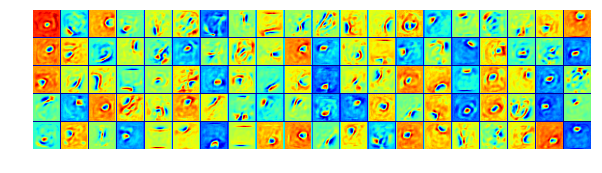

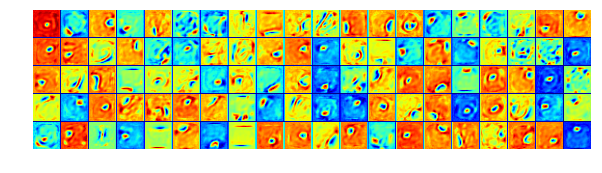

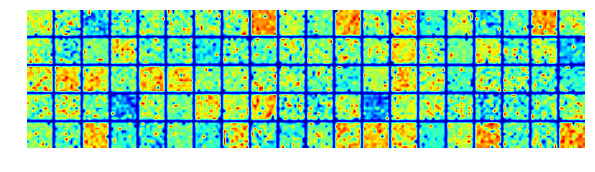

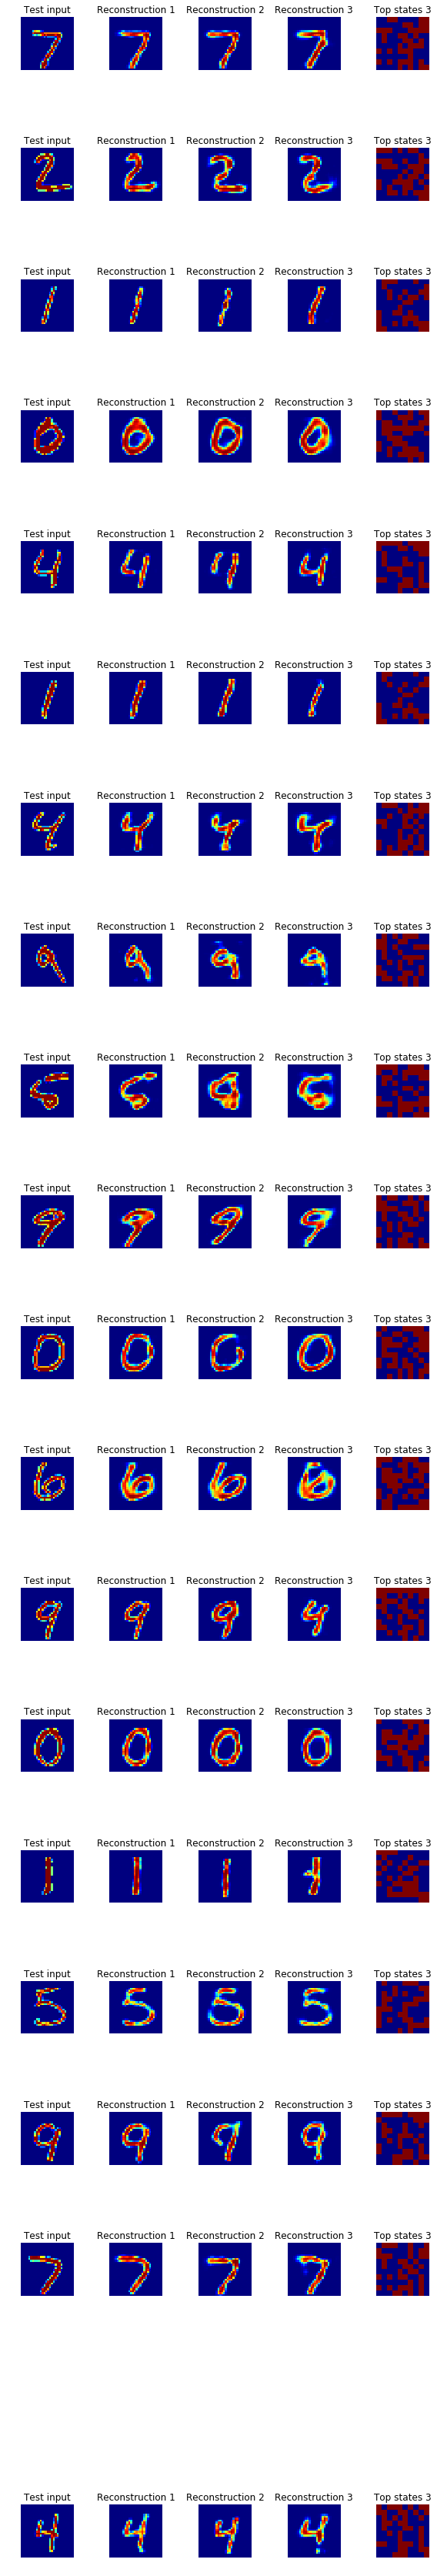

In [128]:
rbm3.plot_all(vr1, vr2)

### 2. RBM hidden size = 784

In [147]:
Nv = 784
v_shape = (28,28)
Nh = 100
h1_shape = (10,10)

Nh2 = 784
h2_shape = (28,28) 

gibbs_sampling_steps = 2
beta = 0.01
w1s, vb1s, hb1s = rbm.get_params()
w2s, vb2s, hb2s = rbm2.get_params()
hb2s = vb1s.copy()


batch_size = 100
epochs = 100

rbm4 = RBM3(Nv, v_shape, Nh, h1_shape, Nh2, h2_shape, beta, w1s, w1s.T)
rbm4.train(batch_size, epochs, mnist)

Batch count:  0   Avg. reconstruction error:  0.04555215
Batch count:  5500   Avg. reconstruction error:  0.02667011
Batch count:  11000   Avg. reconstruction error:  0.025198365
Batch count:  16500   Avg. reconstruction error:  0.026388282
Batch count:  22000   Avg. reconstruction error:  0.02569664
Batch count:  27500   Avg. reconstruction error:  0.025136156
Batch count:  33000   Avg. reconstruction error:  0.026835727
Batch count:  38500   Avg. reconstruction error:  0.024249313
Batch count:  44000   Avg. reconstruction error:  0.025599781
Batch count:  49500   Avg. reconstruction error:  0.026535623


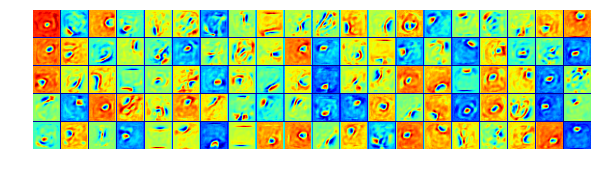

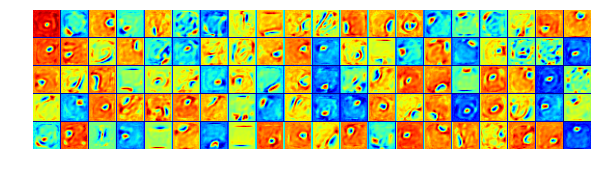

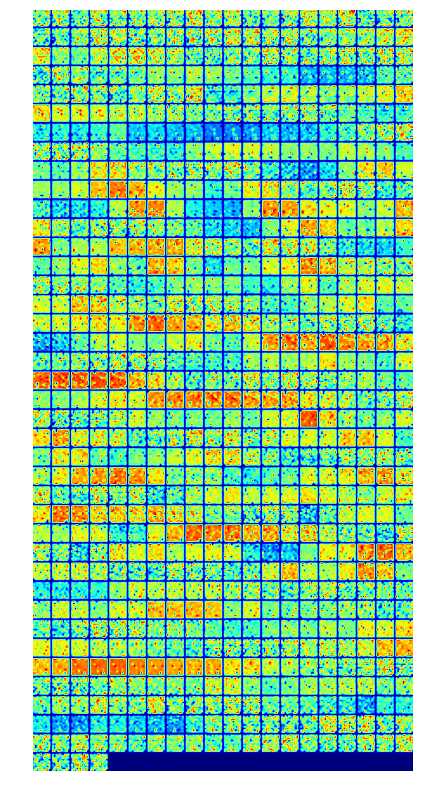

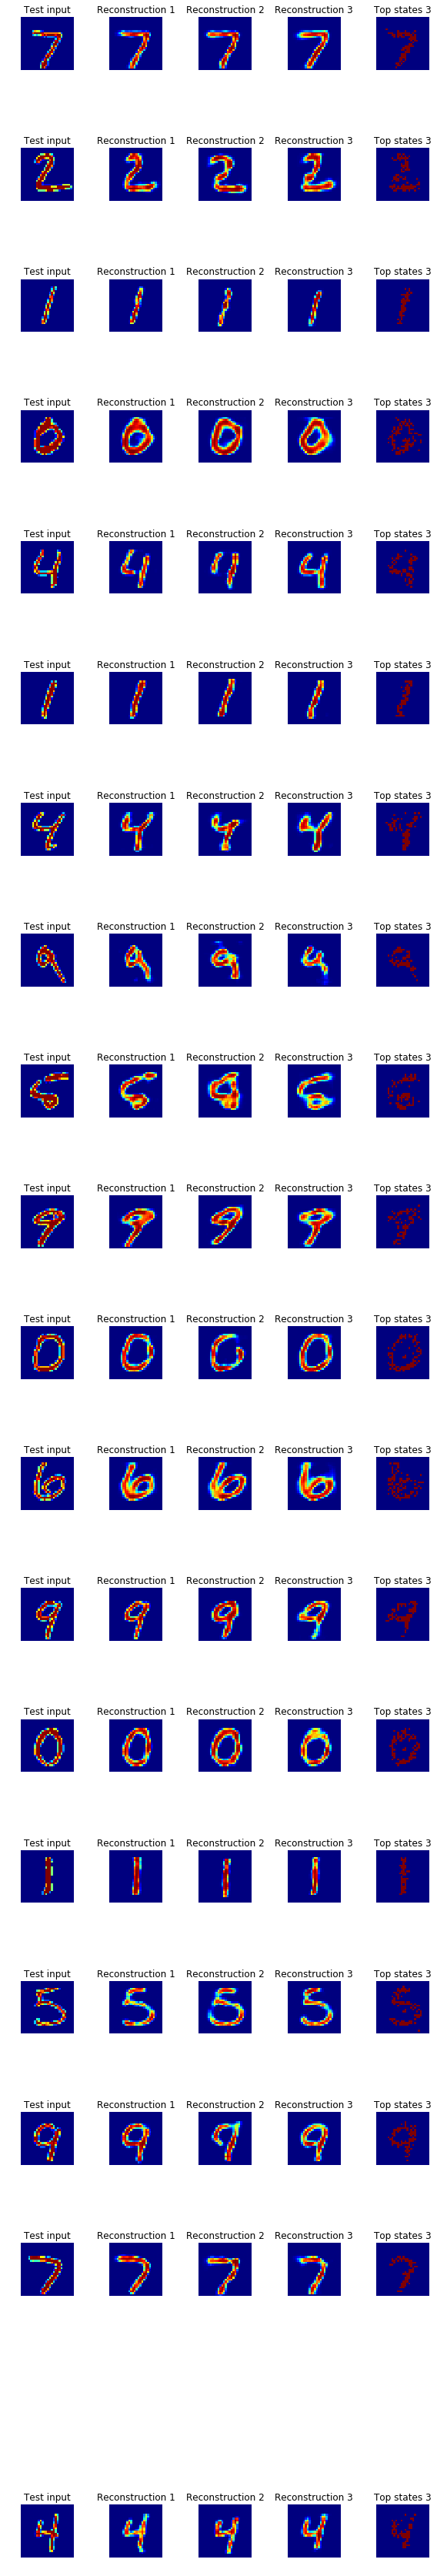

In [130]:
rbm4.plot_all(vr1, vr2)

## ZADATAK 4

In [6]:
def get_canvas(Z, ind, nx, ny, in_shape, batch_size, sess):
    """Crtanje rekonstrukcija na odgovarajućim pozicijama u 2D prostoru skrivenih varijabli
    Z -- skriveni vektori raspoređeni u gridu oko ishodišta
    ind -- indeksi za rezanje Z-a na batch_size blokove za slanje u graf -zbog problema sa random generatorom
    nx -- raspon grida po x osi - skrivena varijabla z0
    ny -- raspon grida po y osi - skrivena varijabla z1
    in_shape -- dimenzije jedne rekonstrukcije i.e. ulazne sličice
    batch_size -- veličina minibatcha na koji je graf naviknut
    sess -- session grafa mreže
    """
    # get reconstructions for visualiations
    X = np.empty((0,in_shape[0]*in_shape[1])) # empty array for concatenation 
    # split hidden vectors into minibatches of batch_size due to TF random generator limitation
    for batch in np.array_split(Z,ind):
        # fill up last batch to full batch_size if neccessary
        # this addition will not be visualized, but is here to avoid TF error
        if batch.shape[0] < batch_size:
            batch = np.concatenate((batch, np.zeros((batch_size-batch.shape[0], batch.shape[1]))), 0)
        # get batch_size reconstructions and add them to array of previous reconstructions
        X = np.vstack((X, sess.run(x_reconstr_mean_out, feed_dict={z: batch})))
    # make canvas with reconstruction tiles arranged by the hidden state coordinates of each reconstruction
    # this is achieved for all reconstructions by clever use of reshape, swapaxes and axis inversion
    return (X[0:nx*ny,:].reshape((nx*ny,in_shape[0],in_shape[1])).swapaxes(0,1)
            .reshape((in_shape[0],ny,nx*in_shape[1])).swapaxes(0,1)[::-1,:,:]
            .reshape((ny*in_shape[0],nx*in_shape[1])))

def draw_reconstructions(ins, outs, states, shape_in, shape_state):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(20):

        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:(shape_state[0] * shape_state[1])].reshape(shape_state),
                   vmin=-4, vmax=4, interpolation="nearest")
        plt.colorbar()
        plt.title("States")
    plt.tight_layout()
    
def plot_latent(inmat, labels):
    """Crtanje pozicija uzoraka u 2D latentnom prostoru
    inmat -- matrica latentnih stanja
    labels -- labela klas
    """
    plt.figure(figsize=(8, 6)) 
    plt.axis([-4, 4, -4, 4])
    plt.gca().set_autoscale_on(False)

    plt.scatter(inmat[:, 0], inmat[:, 1], c=np.argmax(labels, 1))
    plt.colorbar()
    plt.xlabel('z0')
    plt.ylabel('z1')

def save_latent_plot(name):
    """Spremanje trenutnog figure-a
    name -- ime datoteke
    """
    plt.savefig(name)
    
def weight_variable(shape, name):
    """Kreiranje težina"""
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    return tf.get_variable(name, shape=shape,
            initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """Kreiranje pomaka"""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def variable_summaries(var, name):
    """Prikupljanje podataka za Tensorboard"""
    with tf.name_scope(name):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram(name, var)

def vae_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.softplus):
    """Kreiranje jednog skrivenog sloja"""
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        weights = weight_variable([input_dim, output_dim], layer_name + '/weights')
        variable_summaries(weights,'weights')
        tf.summary.tensor_summary('weightsT', weights)
        biases = bias_variable([output_dim])
        variable_summaries(biases, 'biases')
        preactivate = tf.matmul(input_tensor, weights) + biases
        tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
    return activations

### Load MNIST

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 20 skrivenih značajki

In [8]:
learning_rate = 0.001
batch_size = 100

n_hidden_recog_1=200 # 1 sloj enkodera
n_hidden_recog_2=200 # 2 sloj enkodera
n_hidden_gener_1=200 # 1 sloj dekodera
n_hidden_gener_2=200 # 2 sloj dekodera
n_z=20 # broj skrivenih varijabli
n_input=784 # MNIST data input (img shape: 28*28)
in_shape = (28,28)

In [6]:
tf.reset_default_graph() 

sess = tf.InteractiveSession()        
        
# definicije ulaznog tenzora
x = tf.placeholder("float", [None, 784])  

# TODO definirajte enkoiderski dio
layer_e1 = vae_layer(x, n_input, n_hidden_recog_1, 'layer_e1') 
layer_e2 = vae_layer(layer_e1, n_hidden_recog_1, n_hidden_recog_2, 'layer_e2')

with tf.name_scope('z'):
    # definirajte skrivene varijable i pripadajući generator šuma
    z_mean = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_mean', act=tf.identity)
    z_log_sigma_sq = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_log_sigma_sq', act=tf.identity )  
    
    eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
                         
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    tf.summary.histogram('z/activations', z)

    
# definirajte dekoderski dio
layer_d1 = vae_layer(z, n_z, n_hidden_gener_1, 'layer_d1') 
layer_d2 = vae_layer(layer_d1, n_hidden_gener_1, n_hidden_gener_2, 'layer_d2')
            
# definirajte srednju vrijednost rekonstrukcije
x_reconstr_mean = vae_layer(layer_d2, n_hidden_gener_2, n_input, 'x_reconstr_mean', act=tf.identity)
x_reconstr_mean_out = tf.nn.sigmoid(x_reconstr_mean)


# definirajte dvije komponente funkcije cijene
with tf.name_scope('costs'):                         
    # komponenta funkcije cijene - unakrsna entropija
    cost1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstr_mean), 1)  
    tf.summary.histogram('cross_entropy', cost1)
    
    # komponenta funkcije cijene - KL divergencija
    cost2 = -1/2 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)   
    tf.summary.histogram('D_KL', cost2)
    
    cost = tf.reduce_mean(cost1 + cost2)   # average over batch
    tf.summary.histogram('cost', cost)
                         
# ADAM optimizer
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
                         
# Prikupljanje podataka za Tensorboard
merged = tf.summary.merge_all()                  
train_writer = tf.summary.FileWriter('train', sess.graph)


In [7]:
init = tf.global_variables_initializer()                         
sess.run(init)

saver = tf.train.Saver()

n_epochs = 100
total_batch = int(n_samples / batch_size)
for epoch in range(n_epochs):
    avg_cost = 0.
       
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        opt, cos = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        # Compute average loss
        avg_cost += cos / n_samples * batch_size
       
    # Display logs per epoch step
    print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(avg_cost))
    if epoch%(int(n_epochs/10)) == 0:
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_xs},
                              options=run_options, run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'epoch%03d' % epoch)
        train_writer.add_summary(summary, i)
       
        #saver.save(sess, os.path.join('train', "model.ckpt"), epoch)

train_writer.close()

Epoch: 0001 cost= 181.241174122
Epoch: 0002 cost= 135.348855313
Epoch: 0003 cost= 122.837133747
Epoch: 0004 cost= 117.620681860
Epoch: 0005 cost= 114.645909230
Epoch: 0006 cost= 112.383577742
Epoch: 0007 cost= 110.632379400
Epoch: 0008 cost= 109.394729337
Epoch: 0009 cost= 108.250988326
Epoch: 0010 cost= 107.362450825
Epoch: 0011 cost= 106.567980361
Epoch: 0012 cost= 106.003161732
Epoch: 0013 cost= 105.428107605
Epoch: 0014 cost= 104.904647702
Epoch: 0015 cost= 104.526823509
Epoch: 0016 cost= 104.143861667
Epoch: 0017 cost= 103.811293460
Epoch: 0018 cost= 103.442120375
Epoch: 0019 cost= 103.222791152
Epoch: 0020 cost= 102.989859827
Epoch: 0021 cost= 102.677516951
Epoch: 0022 cost= 102.469717338
Epoch: 0023 cost= 102.288809440
Epoch: 0024 cost= 102.019935469
Epoch: 0025 cost= 101.914036685
Epoch: 0026 cost= 101.641595639
Epoch: 0027 cost= 101.534820737
Epoch: 0028 cost= 101.385363950
Epoch: 0029 cost= 101.253870863
Epoch: 0030 cost= 101.121872767
Epoch: 0031 cost= 100.983712588
Epoch: 0

### 2 skrivene značajke

In [9]:
n_z = 2 # broj skrivenih varijabli

In [10]:
tf.reset_default_graph() 

sess = tf.InteractiveSession()        
        
# definicije ulaznog tenzora
x = tf.placeholder("float", [None, 784])  

# TODO definirajte enkoiderski dio
layer_e1 = vae_layer(x, n_input, n_hidden_recog_1, 'layer_e1') 
layer_e2 = vae_layer(layer_e1, n_hidden_recog_1, n_hidden_recog_2, 'layer_e2')

with tf.name_scope('z'):
    # definirajte skrivene varijable i pripadajući generator šuma
    z_mean = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_mean', act=tf.identity)
    z_log_sigma_sq = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_log_sigma_sq', act=tf.identity )  
    
    eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
                         
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    tf.summary.histogram('z/activations', z)

    
# definirajte dekoderski dio
layer_d1 = vae_layer(z, n_z, n_hidden_gener_1, 'layer_d1') 
layer_d2 = vae_layer(layer_d1, n_hidden_gener_1, n_hidden_gener_2, 'layer_d2')
            
# definirajte srednju vrijednost rekonstrukcije
x_reconstr_mean = vae_layer(layer_d2, n_hidden_gener_2, n_input, 'x_reconstr_mean', act=tf.identity)
x_reconstr_mean_out = tf.nn.sigmoid(x_reconstr_mean)


# definirajte dvije komponente funkcije cijene
with tf.name_scope('costs'):                         
    # komponenta funkcije cijene - unakrsna entropija
    cost1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstr_mean), 1)  
    tf.summary.histogram('cross_entropy', cost1)
    
    # komponenta funkcije cijene - KL divergencija
    cost2 = -1/2 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)   
    tf.summary.histogram('D_KL', cost2)
    
    #tf.scalar_summary('cost2', cost2)
    cost = tf.reduce_mean(cost1 + cost2)   # average over batch
    tf.summary.histogram('cost', cost)
                         
# ADAM optimizer
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
                         
# Prikupljanje podataka za Tensorboard
merged = tf.summary.merge_all()                  
train_writer = tf.summary.FileWriter('train', sess.graph)



In [11]:
init = tf.global_variables_initializer()                         
sess.run(init)

saver = tf.train.Saver()

n_epochs = 100
total_batch = int(n_samples / batch_size)
for epoch in range(n_epochs):
    avg_cost = 0.
       
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        opt, cos = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        # Compute average loss
        avg_cost += cos / n_samples * batch_size
       
    # Display logs per epoch step
    print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(avg_cost))
    if epoch%(int(n_epochs/10)) == 0:
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_xs},
                              options=run_options, run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'epoch%03d' % epoch)
        train_writer.add_summary(summary, i)
       
        #saver.save(sess, os.path.join('train', "model.ckpt"), epoch)

train_writer.close()

Epoch: 0001 cost= 190.796273804
Epoch: 0002 cost= 168.428972612
Epoch: 0003 cost= 164.108037470
Epoch: 0004 cost= 160.823795138
Epoch: 0005 cost= 158.151655357
Epoch: 0006 cost= 156.213376215
Epoch: 0007 cost= 154.773608204
Epoch: 0008 cost= 153.530068248
Epoch: 0009 cost= 152.467778154
Epoch: 0010 cost= 151.524061141
Epoch: 0011 cost= 150.713738736
Epoch: 0012 cost= 149.988927807
Epoch: 0013 cost= 149.227058300
Epoch: 0014 cost= 148.575058732
Epoch: 0015 cost= 148.079959328
Epoch: 0016 cost= 147.464391785
Epoch: 0017 cost= 147.034577942
Epoch: 0018 cost= 146.576931374
Epoch: 0019 cost= 146.251730957
Epoch: 0020 cost= 145.926528154
Epoch: 0021 cost= 145.512032720
Epoch: 0022 cost= 145.292976296
Epoch: 0023 cost= 145.046232355
Epoch: 0024 cost= 144.773950140
Epoch: 0025 cost= 144.609718101
Epoch: 0026 cost= 144.381160694
Epoch: 0027 cost= 144.194439115
Epoch: 0028 cost= 144.015556363
Epoch: 0029 cost= 143.886768549
Epoch: 0030 cost= 143.661957037
Epoch: 0031 cost= 143.501357047
Epoch: 0

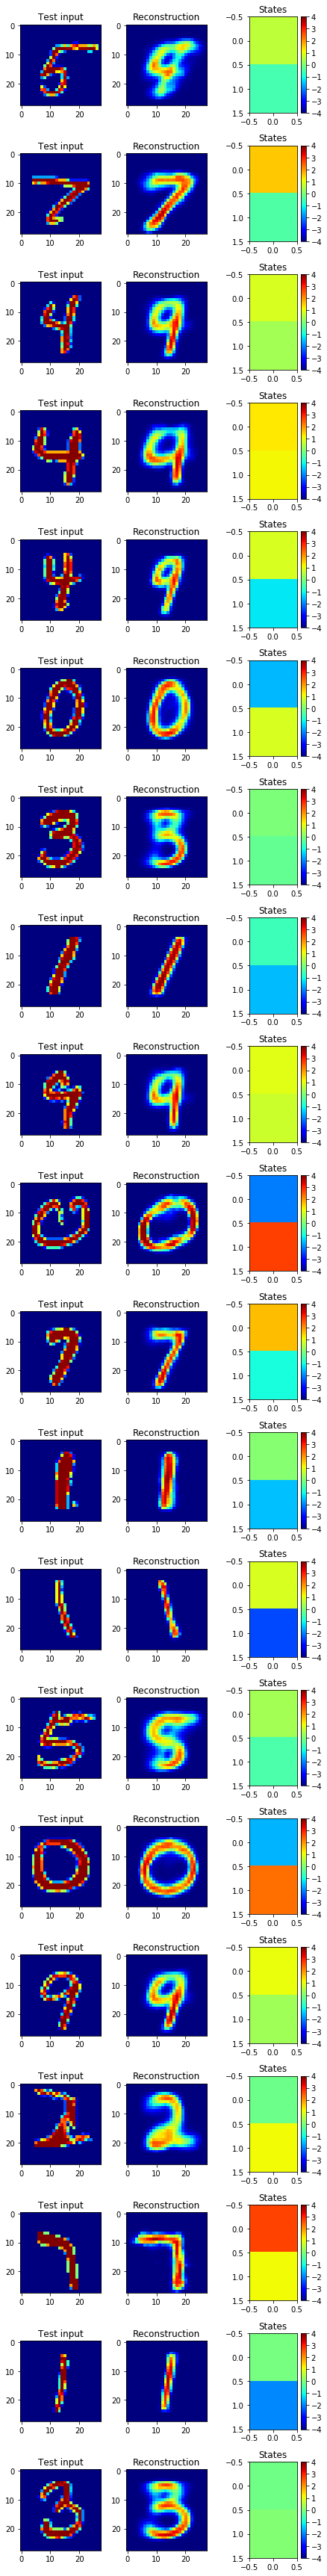

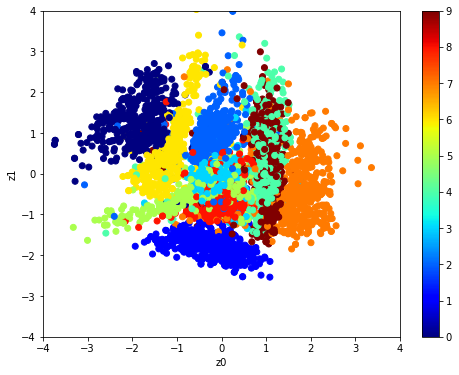

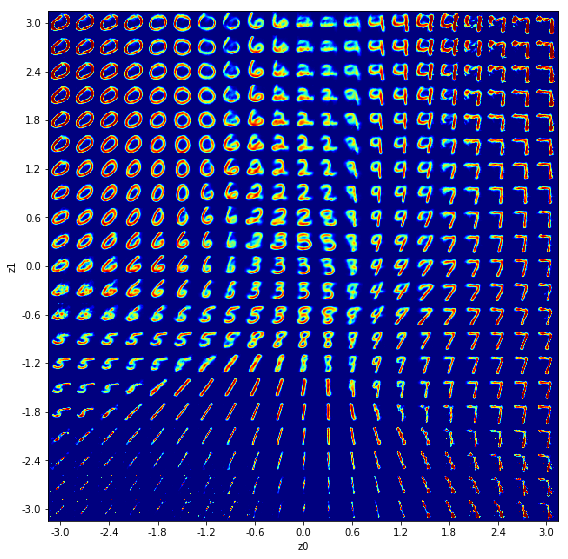

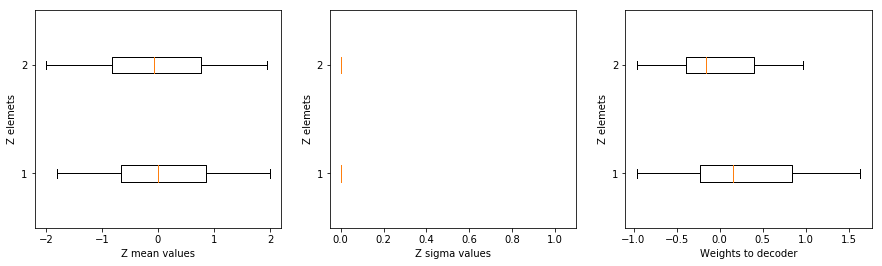

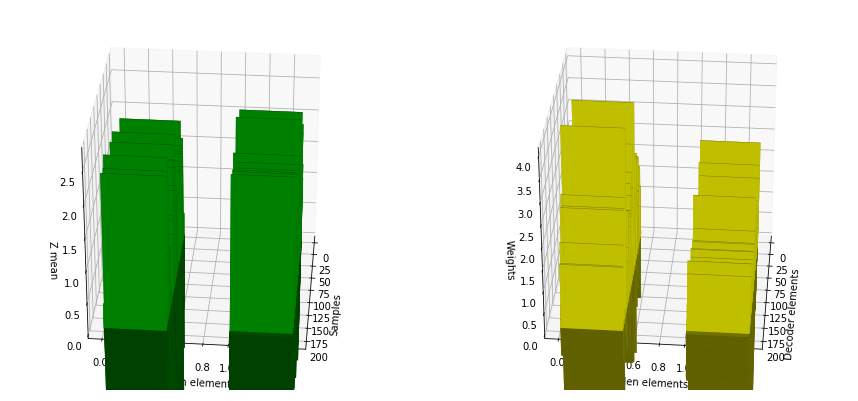

In [28]:
# vizualizacija rekonstrukcije i stanja
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct, z_out = sess.run([x_reconstr_mean_out, z], feed_dict={x: x_sample})

draw_reconstructions(x_sample, x_reconstruct, z_out, (28, 28), (2,1)) # prilagodite dimenzije prema potrebi

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 1. način
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu, z_sigma = sess.run((z_mean, z_log_sigma_sq), feed_dict={x: x_sample})
    
plot_latent(z_mu, y_sample)
#save_latent_plot('trt.png')

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 2. način

nx = ny = 21
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))

# Trikovito popunjavanje rezultata za grid zbog fiksirane veličine z batcha u grafu
# Valjda će se to riješiti u nekoj budućoj verziji TF
Xi, Yi = np.meshgrid(x_values, y_values)
Z = np.column_stack((Xi.flatten(), Yi.flatten()))
X = np.empty((0,28*28))
ind = list(range(batch_size, nx*ny, batch_size))
for i in np.array_split(Z,ind):
    if i.shape[0] < batch_size:
        i = np.concatenate((i, np.zeros((batch_size-i.shape[0], i.shape[1]))), 0)
    X = np.vstack((X, sess.run(x_reconstr_mean_out, feed_dict={z: i})))
    
for i, yi in enumerate(y_values):
    for j, xi in enumerate(x_values):
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = X[i*nx+j].reshape(28, 28)

plt.figure(figsize=(8, 10))
plt.imshow(canvas, origin="upper")
plt.xticks( np.linspace(14,588-14,11), np.round(np.linspace(-3,3,11), 2) )
plt.yticks( np.linspace(14,588-14,11), np.round(np.linspace(3,-3,11), 2) )
plt.xlabel('z0')
plt.ylabel('z1')
plt.tight_layout()

# Vizualizacija ugašenih elemenata skrivenog sloja - 1. način

# Pomoćna funkcija za crtanje boxplot grafova
def boxplot_vis(pos, input_data, label_x, label_y):
    ax = fig.add_subplot(130+pos)
    plt.boxplot(input_data, 0, '', 0, 0.75)
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    return ax
   
fig = plt.figure(figsize=(15,4))

# Vizualizacija statistike za z_mean
boxplot_vis(1,z_mu, 'Z mean values', 'Z elemets')



# Vizualizacija statistike za z_sigma
ax = boxplot_vis(2, np.square(np.exp(z_sigma)), 'Z sigma values', 'Z elemets')
ax.set_xlim([-0.05,1.1])

# Vizualizacija statistike za težine ulaza u dekoder
test = tf.get_default_graph().get_tensor_by_name("layer_d1/weights:0")
weights_d1 = test.eval(session=sess)
boxplot_vis(3, weights_d1.T, 'Weights to decoder', 'Z elemets')


# Vizualizacija ugašenih elemenata skrivenog sloja - 2. način

from mpl_toolkits.mplot3d import Axes3D

# Funkcija za crtanje 3D bar grafa
def bargraph_vis(pos, input_data, dims, color, labels):
    ax = fig.add_subplot(120+pos, projection='3d')
    xpos, ypos = np.meshgrid(range(dims[0]), range(dims[1]))
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)
    
    dx = np.ones_like(zpos) 
    dy = np.ones_like(zpos) * 0.5
    dz = input_data.flatten()
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=color)
    ax.view_init(elev=30., azim=5)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
                             
fig = plt.figure(figsize=(15,7))


# 3D bar graf za z_mean
labels = ('Samples', 'Hidden elements', 'Z mean')
bargraph_vis(1, z_mu[0:200], [200, z_mu.shape[1]], 'g', labels)

# 3D bar graf za težine iz z_mena u dekoder
labels = ('Decoder elements', 'Hidden elements Z', 'Weights')
bargraph_vis(2, weights_d1.T, weights_d1.T.shape, 'y', labels)
